We will prepare tensor binary files from imagenette (valid) dataset for C runtime here.

In [ ]:
from fastai.vision.all import *
from torch.utils.data import Dataset
import struct
from torchvision.transforms.functional import to_pil_image

# Generating Test dataset (224\*224) for C runtime
- in torch.tensor format
- stored in a binary file

In [ ]:
path = untar_data(URLs.IMAGENETTE_320,data=Path.cwd()/'data')
dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=Resize(224),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats),)
learn = vision_learner(dls, resnet18, metrics=accuracy, pretrained=True)

If model parameters were saved in a file previously, load those previously trained parameters. Otherwise, run `finetune` and save those newly trained parameters into a file for the future use.

In [ ]:
fn = path/'model.pth'
if os.path.exists(fn):
    learn.model.load_state_dict(torch.load(fn))
else:
    learn.fine_tune(1)
    torch.save(learn.model.state_dict(), fn)    

We'll generate `test` dataset while running inference for `validation` dataset. `test` dataset is augmented from `valid` dataset and stored in `tensor` format for C runtimes.

In [ ]:
class SaveImageFilesCallback(Callback):
    def __init__(self, save_dir, ncat=10, nitems=100):
        self.save_dir = save_dir
        self.ncat = ncat
        self.counts = [0] * int(nitems/ncat)
        for i in range(self.ncat):
            os.makedirs(save_dir/str(i), exist_ok=True)
   
    def after_batch(self):
        if self.learn.training or self.learn.model.training:
            return
        for X,y in zip(self.learn.xb[0], self.learn.y):
            if self.counts[y] >= self.ncat:
                continue
            
            fn = f'{str(self.save_dir)}/{y.item()}/{self.counts[y]}'
            with open(fn+'.bin', "wb") as f:
                f.write(struct.pack('f'*X.numel(), *X.flatten()))                
            PILImage.create(TensorImage(X)).save(fn+'.jpg')
            
            self.counts[y] += 1
            if sum(self.counts)==self.ncat*len(self.dls.vocab):
                break

In [ ]:
%%time
learn.validate(cbs=SaveImageFilesCallback(path/'test'))

CPU times: user 10min 57s, sys: 2min 4s, total: 13min 1s
Wall time: 2min 30s


(#2) [7.440341472625732,0.051974523812532425]

## Test dataset directory structure

In [ ]:
!tree -d data/imagenette2-320/test
!ls -al data//imagenette2-320/test/[2,6]/[3,7].{bin,jpg}

data/imagenette2-320/test
├── 0
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
└── 9

10 directories
-rw-rw-r-- 1 doyu doyu 602112 Apr 18 19:31 data//imagenette2-320/test/2/3.bin
-rw-rw-r-- 1 doyu doyu  10635 Apr 18 19:31 data//imagenette2-320/test/2/3.jpg
-rw-rw-r-- 1 doyu doyu 602112 Apr 18 19:31 data//imagenette2-320/test/2/7.bin
-rw-rw-r-- 1 doyu doyu  19296 Apr 18 19:31 data//imagenette2-320/test/2/7.jpg
-rw-rw-r-- 1 doyu doyu 602112 Apr 18 19:30 data//imagenette2-320/test/6/3.bin
-rw-rw-r-- 1 doyu doyu  10320 Apr 18 19:30 data//imagenette2-320/test/6/3.jpg
-rw-rw-r-- 1 doyu doyu 602112 Apr 18 19:30 data//imagenette2-320/test/6/7.bin
-rw-rw-r-- 1 doyu doyu  13007 Apr 18 19:30 data//imagenette2-320/test/6/7.jpg


# Store test dataset on HuggigngFace Datasets

Restoring an image from a tensor binary file

In [ ]:
#|export
def denormalize(x, stats=imagenet_stats):
    mean, std = [torch.tensor(o).view(3,1,1) for o in stats]
    return x * std + mean

def BinImageCreate(fn, stats=imagenet_stats):
    with open(fn, "rb") as f:
        x = struct.unpack(f'{3*224*224}f', f.read())
    x = torch.tensor(x).view(3, 224, 224)
    return x

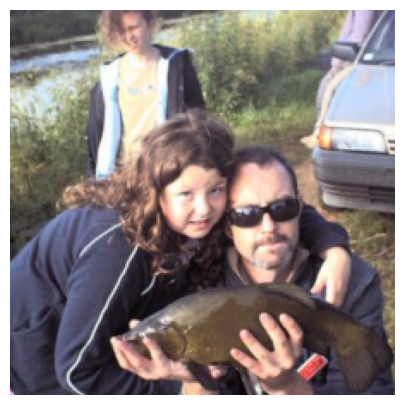

In [ ]:
fn = path/'test'/'0'/'0.bin'
x = BinImageCreate(fn, imagenet_stats)
x = denormalize(x, imagenet_stats)
show_image(PILImage(to_pil_image(x)));

# Inference with `learn.model`

save `learner` to use later, and then, load `learner` & run inference for `test` dataset

In [ ]:
test_path = path/'test'
test_files = get_files(test_path, extensions='.bin')
test_dls = DataBlock(
    blocks=(TransformBlock(type_tfms=BinImageCreate), CategoryBlock),
    get_items=lambda x: test_files,  # We already have the list of test files
    splitter=IndexSplitter([]),  # No need to split as we're only dealing with test data
    get_y=parent_label,
).dataloaders(test_path, bs=64)

In [ ]:
learn.validate(dl=test_dls.train)  # Using the test DataLoader for validation

(#2) [0.08956775069236755,0.984375]

In [ ]:
learn.export()
learn = load_learner(path/'export.pkl')

In [ ]:
learn.validate(dl=test_dls.train)

(#2) [0.003503329586237669,1.0]